In [2]:
%%capture
%matplotlib inline
#Block output of installs and determine plot output 

#Install and upgrade relevant libraries
!pip install seaborn yahooquery PyPDF2 --upgrade                                            

#Import all relevant libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import Ticker
import numpy as np
from PyPDF2 import PdfReader
import os
from datetime import date as dt
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor

#Block warnings and set displayed dataframe settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)                                                        
pd.set_option('max_colwidth', 1000)                                                            

In [6]:
#INTERACTIONS AND ARTICLES PUBLISHED PER MONTH FOR THESE KEYWORDS: CSR, CLIMATE CHANGE, ESG, GLOBAL WARMING, GREENHOUSE GAS, NDC, POLLUTION, SDG

#Import data
mon_2014 = pd.read_excel("Source_Data/Monthly_KW/2014.xlsx",header=0)
mon_2015 = pd.read_excel("Source_Data/Monthly_KW/2015.xlsx",header=0)
mon_2016 = pd.read_excel("Source_Data/Monthly_KW/2016.xlsx",header=0)
mon_2017 = pd.read_excel("Source_Data/Monthly_KW/2017.xlsx",header=0)
mon_2018 = pd.read_excel("Source_Data/Monthly_KW/2018.xlsx",header=0)
mon_2019 = pd.read_excel("Source_Data/Monthly_KW/2019.xlsx",header=0)
mon_2020 = pd.read_excel("Source_Data/Monthly_KW/2020.xlsx",header=0)
mon_2021 = pd.read_excel("Source_Data/Monthly_KW/2021.xlsx",header=0)
mon_2022 = pd.read_excel("Source_Data/Monthly_KW/2022.xlsx",header=0)
mon_2023 = pd.read_excel("Source_Data/Monthly_KW/2023.xlsx",header=0)

#Define data wrangling function
def wrangle(df):

    #Drops columns
    df.drop(['Link','Authors','Pinterest','LinkedIn','Twitter Influencer Shares','Total Facebook','Likes','Shares','Comments'],axis=1,inplace=True)

    #Converts published column to datetime format and converts article title to lowercase
    df['Published'] = pd.to_datetime(df['Published'],format='%Y-%m-%dT%H:%M:%S%z')
    df['Headline'] = df['Headline'].str.lower()

    #Renames and reorders columns
    df.rename(columns={'Published':'Date','Group':'Keyword','Headline':'Title','Total Interactions':'Interactions'},inplace=True)
    df = df.reindex(columns=['Date','Month','Keyword','Title','Website','Interactions'])

    #Extracts the month from the date column and converts it to a string
    df['Month'] = df['Date'].dt.to_period('M')
    df['Month'] = df['Month'].astype('str')
    return df

#Categorizes keywords to increase visibility and isolate CSR
def kw_categorize(keyword):
    if keyword in ['Climate Change','Global Warming','Greenhouse gas','Pollution']:
        return 'Climate'
    elif keyword == 'CSR':
        return 'CSR'
    elif keyword in ['ESG','NDC','SDG']:
        return 'Sustainability (ESG, NDC, SDG)'

#Concatenates wrangled data
mon_kw = pd.concat([wrangle(mon_2014),wrangle(mon_2015),wrangle(mon_2016),wrangle(mon_2017),wrangle(mon_2018),wrangle(mon_2019),wrangle(mon_2020),wrangle(mon_2021),\
                    wrangle(mon_2022),wrangle(mon_2023)],axis=0,ignore_index=True)

#Runs the categorize function on the keyword column and appends a new column containing the category
mon_kw['Keyword Category'] = mon_kw['Keyword'].apply(kw_categorize)

#Reorder columns
mon_kw = mon_kw.reindex(columns=['Date','Month','Keyword','Keyword Category','Title','Website','Interactions'])

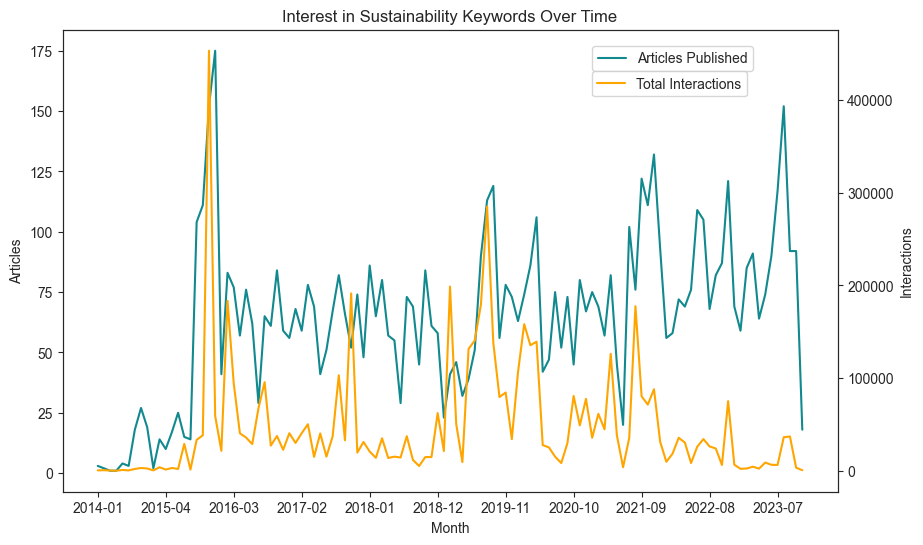

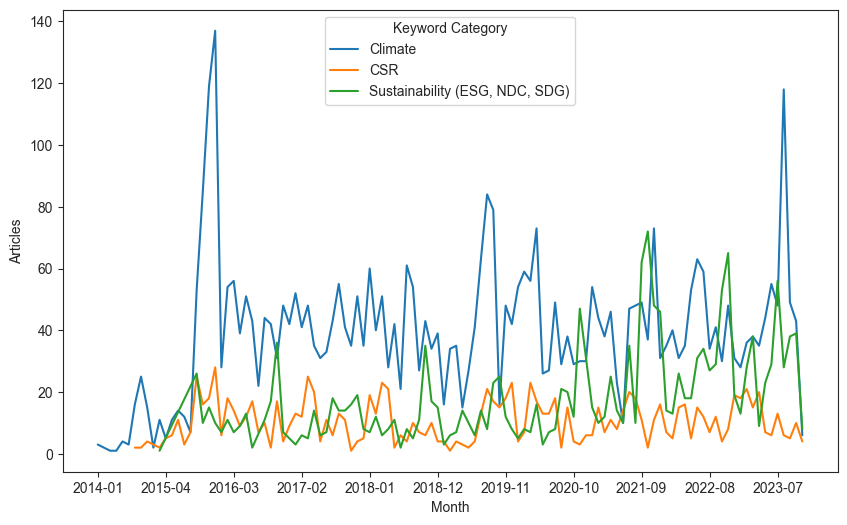

In [22]:
#LINEGRAPH - ARTICLES VS INTERACTIONS FOR ALL KEYWORDS
#Groupby Month, count number of keyword articles, and sums interactions then resets index
forviz = mon_kw[['Month','Keyword','Interactions']].groupby(['Month']).agg({'Keyword':'count','Interactions':'sum'}).rename(columns={'Keyword':'Articles'})
forviz.reset_index(inplace=True)

#Set figure size and style
plt.figure(figsize=(10,6))
sns.set_style('ticks')

#Plots linegraph with Month on the x-axis and Number of articles on the left y-axis
sns.lineplot(data=forviz,x='Month',y='Articles',label='Articles Published',color='#11898E')

#Plots legend in the top right corner, adjust positions slightly to match second legend and aligns text to the left
plt.legend(loc='upper right',bbox_to_anchor=(1-0.1,0.98),alignment='left')

#Defines second axis to be on the same plot but on the right y-axis
ax2 = plt.twinx()

#Plots the second line graph on the same plot with Month on the x-axis and Total interactions on the right y-axis
sns.lineplot(data=forviz,x='Month',y='Interactions',label='Total Interactions',color='orange')

#Plots second legend to be just under the first legend
plt.legend(loc='upper right',bbox_to_anchor=(0.992-0.1,0.925),alignment='left')

#Defines first axis as the current axis
ax1 = plt.gca()

#Sets the x ticks as evenly spaced values across the entire available months
ax2.set_xticks(forviz['Month'].tolist()[0::11])

#Sets labels, titles, then displays the plot
ax1.set_ylabel("# of Articles")
ax2.set_ylabel("Interactions")
plt.title('Interest in Sustainability Keywords Over Time')
plt.show()




#LINEGRAPH - NUMBER OF ARTICLES SPLIT BY KEYWORD
#Groupby Month and Keyword Category, counts each, renames the column then resets index
keywordz = mon_kw[['Month','Keyword Category','Title']].groupby(['Month','Keyword Category']).count().rename(columns={'Title':'Articles'})
keywordz.reset_index(inplace=True)

#Sets figure size and style
plt.figure(figsize=(10,6))
sns.set_style('ticks')

#Plots linegraph with Month on the x-axis, Articles on the y-axis, keyword categories distinguished by color, and sets the x ticks to be evenly spaced across all months
sns.lineplot(data=keywordz,x='Month',y='Articles',hue='Keyword Category').set_xticks(forviz['Month'].tolist()[0::11])
plt.show()

In [69]:
#REVENUE PER SHARE VS TOTAL ESG SCORE

#Imports tickers of top 50 largest companies in Indonesia by market cap into a dataframe. '.JK' is appended to each name as this is the format found on Yahoo Finance
df1 = pd.DataFrame({'Tickers':[x+'.JK' for x in\
                    list(pd.read_excel("Source_Data/Indo_50_Biggest_Companies.xlsx",sheet_name="50 Biggest Market Capitalizatio",header=3,nrows=51,usecols=[2])['Code'])[1:]]})

def fetch_data_for_ticker(ticker):
    data = [ticker]
    
    #Define function of pulling data from Yahoo Finance using tickers. Datatype specifies which data to pull from Yahoo Finance
    def yahoodata(row,datatype):
        #Define try block which will return None if no data available for that ticker
        try:
            #Returns the relevant financial data based on datatype and ticker
            x = Ticker(str(row))
            if datatype == 'revenuePerShare' or datatype == 'currentPrice':
                return x.financial_data[str(row)][datatype]
            elif datatype == 'totalEsg':
                return x.esg_scores[str(row)][datatype]
        except:
            return np.nan
            
    return tuple([str(ticker)] + [yahoodata(str(ticker),'currentPrice')] + [yahoodata(ticker,'revenuePerShare')] + [yahoodata(ticker,'totalEsg')])

with ThreadPoolExecutor(max_workers=10) as executor:
   results = executor.map(fetch_data_for_ticker,df1['Tickers'])

for result in results:
#    ticker, current_price, revenue_per_share, total_esg = result
#    df1.loc[df1['Tickers'] == ticker, 'Current Share Price'] = current_price
#    df1.loc[df1['Tickers'] == ticker, 'Revenue per Share'] = revenue_per_share
#    df1.loc[df1['Tickers'] == ticker, 'Total ESG Rating'] = total_esg

In [70]:
for x in results:
    print(x[0])

BBCA.JK
BBRI.JK
BREN.JK
BYAN.JK
BMRI.JK
AMMN.JK
TLKM.JK
TPIA.JK
ASII.JK
BBNI.JK
UNVR.JK
ICBP.JK
AMRT.JK
HMSP.JK
BRPT.JK
CPIN.JK
UNTR.JK
SMMA.JK
DCII.JK
ADRO.JK
KLBF.JK
ISAT.JK
MBMA.JK
GOTO.JK
BRIS.JK
DNET.JK
MEGA.JK
MYOR.JK
NCKL.JK
CUAN.JK
PANI.JK
PGEO.JK
INDF.JK
BELI.JK
MDKA.JK
INKP.JK
MTEL.JK
INCO.JK
TBIG.JK
TOWR.JK
ADMR.JK
GGRM.JK
TCPI.JK
BNGA.JK
BUMI.JK
SMGR.JK
ANTM.JK
DSSA.JK
MIKA.JK
SUPR.JK


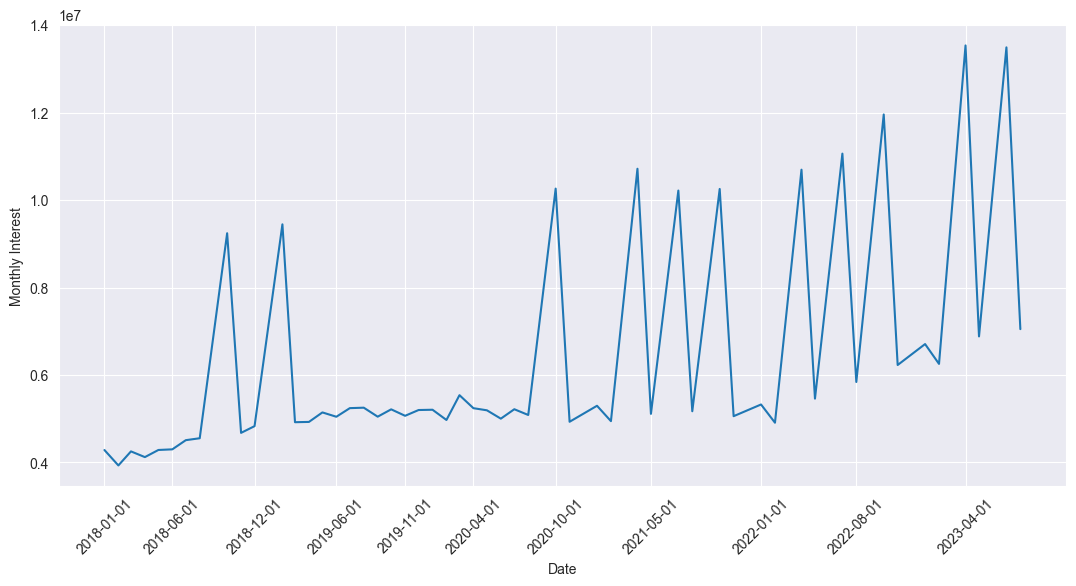

In [101]:
def revenue(companyname):
    directory = '.\\Source_data\\Companies\\' + companyname
    month = []
    revenue = []
    for filename in os.listdir(directory):
        month.append(datetime(int(filename[4:8]),int(filename[9:11]),1))
        
        reader = PdfReader(os.path.join(directory,filename))
        pos = reader.pages[2].extract_text().find('Pendapatan Bunga')
        rev_data = reader.pages[2].extract_text()[pos+16:pos+28]
        revenue.append(int(rev_data.strip().replace('.','')))
    df = pd.DataFrame({'Date':month,'Cumulative Interest':revenue})
    df['Monthly Interest'] = df['Cumulative Interest'] - df['Cumulative Interest'].shift(fill_value=0)
    df.loc[df['Monthly Interest'] < 0,'Monthly Interest'] = df.loc[df['Monthly Interest'] < 0,'Cumulative Interest']
    df.drop(columns='Cumulative Interest',inplace=True)
    return df

BCA = revenue('BCA')
plt.figure(figsize=(13,6))
sns.lineplot(data=BCA,x='Date',y='Monthly Interest')
plt.xticks([BCA['Date'].tolist()[x] for x in list(range(0,54,5))],rotation=45)

plt.show()

In [51]:
data = pd.read_excel("Source_Data/Company_and_ESG_KW/Company_and_ESG_2018.xlsx",header=0)
data.drop(['Link','Authors','Pinterest','LinkedIn','Twitter Influencer Shares','Total Facebook','Likes','Shares','Comments'],axis=1,inplace=True)
data['Published'] = data['Published'].apply(lambda x: datetime(int(x[0:4]),int(x[5:7]),int(x[8:10])))